In [1]:
#The ESIM seems complex, let's make it first
#following almostly copied from yjqiang 
#reference:https://blog.csdn.net/jesseyule/article/details/100579295

import os
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super().__init__()
        self.bi_lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, bidirectional=True, batch_first=True)

    def forward(self, tensor_sentences, length_list):
        packed_sentences = pack_padded_sequence(tensor_sentences, length_list, batch_first=True, enforce_sorted=False)
        output, _ = self.bi_lstm(packed_sentences)
        result, _ = pad_packed_sequence(output, batch_first=True)
        return result

![alt text](encoder.png)

![alt text](whatesimcando.png)

In [2]:
class LocalInferenceModeling(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=2)  # -1

    def attention(self, x1_bar, length_list1, x2_bar, length_list2):
        e = torch.bmm(x1_bar, x2_bar.transpose(1, 2))  # shape: (batch_size, max_sentence_length1, max_sentence_length2)

        batch_size, max_sentence_length1, max_sentence_length2 = e.shape

        #to get rid of pad
        mask1 = torch.ge(torch.arange(max_sentence_length1).expand(batch_size, -1), length_list1.unsqueeze(-1))
        mask2 = torch.ge(torch.arange(max_sentence_length2).expand(batch_size, -1), length_list2.unsqueeze(-1))

        softmax_e = self.softmax(e.masked_fill(mask2.unsqueeze(1), float('-inf')))
        x1_tilde = torch.bmm(softmax_e, x2_bar)

        softmax_e = self.softmax(e.transpose(1, 2).masked_fill(mask1.unsqueeze(1), float('-inf')))
        x2_tilde = torch.bmm(softmax_e, x1_bar) 
        return x1_tilde, x2_tilde

    @staticmethod
    def enhancement(x_bar, x_tilde):
        return torch.cat([x_bar, x_tilde, x_bar - x_tilde, x_bar * x_tilde], dim=-1)

    def forward(self, x1_bar, length_list1, x2_bar, length_list2):
        x1_tilde, x2_tilde = self.attention(x1_bar, length_list1, x2_bar, length_list2)
        return self.enhancement(x1_bar, x1_tilde), self.enhancement(x2_bar, x2_tilde)

![alt text](attention1.png)
![alt text](attention2.png)
![alt text](enhance.png)

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, class_num):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, class_num)

    def forward(self, x):
        return self.fc2(self.tanh(self.fc1(x)))

class InferenceComposition(nn.Module):
    def __init__(self, input_size, hidden_size, class_num):
        super().__init__()
        self.F = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.BiLSTM = BiLSTM(hidden_size, hidden_size // 2)

        self.MLP = MLP(4 * hidden_size, hidden_size, class_num)

    def handle_x(self, m_x, length_list):
        v_x_t = self.BiLSTM(self.relu(self.F(m_x)), length_list)

        max_sentence_length = m_x.shape[1]
        v_x_t_transpose = v_x_t.transpose(1, 2)
        v_x_avg = F.avg_pool1d(v_x_t_transpose, kernel_size=max_sentence_length).squeeze(-1)
        v_x_max = F.max_pool1d(v_x_t_transpose, kernel_size=max_sentence_length).squeeze(-1)
        return torch.cat([v_x_avg, v_x_max], dim=1)

    def forward(self, m_x1: torch.Tensor, seq_lengths1: torch.Tensor, m_x2: torch.Tensor, seq_lengths2: torch.Tensor) -> torch.Tensor:
        v = torch.cat([self.handle_x(m_x1, seq_lengths1), self.handle_x(m_x2, seq_lengths2)], dim=-1)  # shape: (batch_size, 4 * hidden_size)  
        return self.MLP(v)


class ESIM(nn.Module):
    def __init__(self, embedding_dim, vocab_dim, hidden_size, class_num, embedding, pad_idx):
        super().__init__()
        if embedding:
            self.embedding = embedding
        else:
            self.embedding = nn.Embedding(vocab_dim, embedding_dim, padding_idx=pad_idx)

        self.BiLSTM = BiLSTM(embedding_dim, hidden_size // 2)
        self.LocalInferenceModeling=LocalInferenceModeling()
        self.InferenceComposition = InferenceComposition(input_size=hidden_size*4, hidden_size=hidden_size, class_num=class_num)
        
    def forward(self, x1, length_list1, x2, length_list2):
        x1_ = self.embedding(x1)  # 论文中的 a；shape: (batch_size, max_sentence_length1, embedding_size)
        x2_ = self.embedding(x2)  # 论文中的 b；shape: (batch_size, max_sentence_length2, embedding_size)

        # 3.1  INPUT ENCODING
        x1_bar = self.BiLSTM(x1_, length_list1)  # 论文中的 a_bar；shape: (batch_size, max_sentence_length1, hidden_size)
        x2_bar = self.BiLSTM(x2_, length_list2)  # 论文中的 b_bar；shape: (batch_size, max_sentence_length2, hidden_size)

        # 3.2 Local Inference Modeling
        m_x1, m_x2 = self.LocalInferenceModeling(x1_bar, length_list1, x2_bar, length_list2)  # 论文中的 ma/mb；shape: (batch_size, max_sentence_length_i, hidden_size*4)

        # 3.3 INFERENCE COMPOSITION
        scores = self.InferenceComposition(m_x1, length_list1, m_x2, length_list2)  # scores shape: (batch_size, class_num
        return scores

In [11]:
#too tedious ... let's take a break ...


In [17]:
def read_json(path):
    label2index = {'contradiction': 0, 'entailment': 1, 'neutral': 2}
    x1 = []
    x2 = []
    labels = []
    with open(path, 'r') as f:
        for line in f:
            line = json.loads(line)
            if line['gold_label'] == '-':
                continue
            x1.append(line['sentence1'])
            x2.append(line['sentence2'])
            labels.append(label2index[line['gold_label']])
    return x1, x2, labels

import json
train_path = '../data/snli_1.0/snli_1.0_train.jsonl'
dev_path = '../data/snli_1.0/snli_1.0_dev.jsonl'
test_path = '../data/snli_1.0/snli_1.0_test.jsonl'

def clean_text(x1, x2, y):
    x1 = [i.lower() for i in x1]
    x1 = [re.sub(r'[^A-Za-z]+', ' ', i) for i in x1]
    x2 = [i.lower() for i in x2]
    x2 = [re.sub(r'[^A-Za-z]+', ' ', i) for i in x2]

    x1_, x2_, y_ = [], [], []
    for i in range(len(x1)):
        if x1[i].split() and x2[i].split():
            x1_.append(x1[i])
            x2_.append(x2[i])
            y_.append(y[i])
    return x1_, x2_, y_

x_train1_orig, x_train2_orig, y_train_orig = read_json(train_path)
x_dev1_orig, x_dev2_orig, y_dev_orig = read_json(dev_path)

length = 50000

x_train1, x_train2, y_train = clean_text(x_train1_orig[:length], x_train2_orig[:length], y_train_orig[:length])
x_dev1, x_dev2, y_dev = clean_text(x_dev1_orig, x_dev2_orig, y_dev_orig)

print(len(x_train1))


50000


In [18]:
#simple build dict
def build_dict(x):
    ret = []
    for i in x:
        ret += [j for j in i.split()]
    return list(set(ret))

d = build_dict(x_train1+x_train2+x_dev1+x_dev2)

word2idx = {d[i]:i for i in range(len(d))}

pad_idx = len(word2idx)

word2idx["<pad>"] = pad_idx

vocab_size = len(word2idx)

n_classes = 3

print("vocab_size: ", vocab_size)



vocab_size:  13439


In [20]:
#Build datalodaer
batch_size = 400

class mydataset(torch.utils.data.Dataset):
    def __init__(self, x1:torch.Tensor, x2:torch.Tensor, y:torch.Tensor, length_list1, length_list2):
        self.x1 = x1
        self.x2 = x2
        self.y = y
        self.length_list1 = length_list1
        self.length_list2 = length_list2
    def __getitem__(self, index):
        x1 = self.x1[index]
        x2 = self.x2[index]
        labels = self.y[index]
        length1 = self.length_list1[index]
        length2 = self.length_list2[index]
        return x1, x2, labels, length1, length2
    def __len__(self):
        return len(self.x1)

def get_idx(word):
    try:
        return word2idx[word]
    except:
        return word2idx['unknown']

def sentence2vector(sentence):
    return [get_idx(word) for word in sentence.split()]

def padding(x, max_length):
    length = 0
    for i in range(max_length - len(x)):
        x.append(word2idx["padding"])
    return x

def get_dataloader(x1, x2, y):
    inputs1 = [sentence2vector(s) for s in x1]

    inputs2 = [sentence2vector(s) for s in x2]

    length_list1 = [len(i) for i in inputs1]

    length_list2 = [len(i) for i in inputs2]

    max_length1 = max(length_list1)
    max_length2 = max(length_list2)

    inputs1 = torch.tensor([padding(s, max_length1) for s in inputs1])

    inputs2 = torch.tensor([padding(s, max_length2) for s in inputs2])

    targets =  torch.tensor(y, dtype=torch.long)

    dataset = mydataset(inputs1, inputs2, targets, length_list1, length_list2)

    dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=batch_size)

    return dataloader

train_dataloader = get_dataloader(x_train1, x_train2, y_train)

test_dataloader = get_dataloader(x_dev1, x_dev2, y_dev)

In [21]:
#test model

loss = nn.CrossEntropyLoss()

#embedding_dim, vocab_dim, hidden_size, class_num, embedding

net = ESIM(embedding_dim=100, vocab_dim=vocab_size, hidden_size=20, class_num=n_classes, embedding=None, pad_idx=pad_idx)

optimizer = optim.SGD(net.parameters(), lr=0.01)

for i, (inputs1, inputs2, targets, length_list1, length_list2) in enumerate(train_dataloader):
    net.zero_grad()

    probs = net(inputs1, length_list1, inputs2, length_list2)

    loss = loss(probs, targets)

    loss.backward()

    optimizer.step()
    break


In [24]:
#Train
def pretty_time(time, degree=1):
    return str(int(time // 60)) + "m" + str(round(time % 60, degree)) if time > 60 else round(time, degree)

def train():
    
    criterion =  nn.CrossEntropyLoss()

    optimizer = optim.Adam(net.parameters(), lr=0.005)

    epoch = 10

    start_time = time.time()

    loss_list = []

    print("dataloader length: ", len(train_dataloader))

    for i in range(epoch):
        total_loss = 0.
        for j, (inputs1, inputs2, targets, length_list1, length_list2) in enumerate(train_dataloader):

            probs = net(inputs1, length_list1, inputs2, length_list2)

            net.zero_grad()
  
            loss = criterion(probs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            if (j+1) % 30 == 0 and j:
                time_past = time.time() - start_time
                cur_loss = total_loss
                loss_list.append(cur_loss)
                total_loss = 0
                print("epoch: ", i, "batch: ", round(j * batch_size), " time: ", pretty_time(time_past), "loss: ", cur_loss)

    plt.plot(loss_list)

    plt.show()

dataloader length:  125
epoch:  0 batch:  11600  time:  14.0 loss:  31.758915662765503
epoch:  0 batch:  23600  time:  27.6 loss:  29.585267961025238
epoch:  0 batch:  35600  time:  40.7 loss:  27.718307435512543
epoch:  0 batch:  47600  time:  54.0 loss:  26.029936134815216
epoch:  1 batch:  11600  time:  1m9.4 loss:  23.666109144687653
epoch:  1 batch:  23600  time:  1m23.3 loss:  22.76715987920761
epoch:  1 batch:  35600  time:  1m36.7 loss:  21.459296941757202
epoch:  1 batch:  47600  time:  1m50.0 loss:  20.266930758953094
epoch:  2 batch:  11600  time:  2m5.3 loss:  19.291612684726715
epoch:  2 batch:  23600  time:  2m19.2 loss:  18.63268083333969
epoch:  2 batch:  35600  time:  2m32.4 loss:  17.97227120399475
epoch:  2 batch:  47600  time:  2m45.6 loss:  17.14851999282837
epoch:  3 batch:  11600  time:  3m1.0 loss:  16.322709769010544
epoch:  3 batch:  23600  time:  3m14.5 loss:  15.982906430959702
epoch:  3 batch:  35600  time:  3m27.8 loss:  15.57234811782837
epoch:  3 batch: 

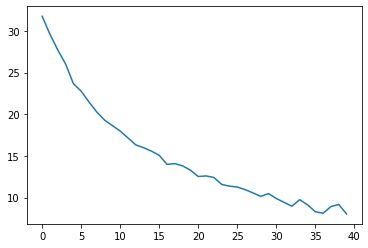

In [25]:
net = ESIM(embedding_dim=100, vocab_dim=vocab_size, hidden_size=20, class_num=n_classes, embedding=None, pad_idx=pad_idx)

train()

In [ ]:
#WTF? too  fXXXXXXX slow , let's take a break 

In [30]:
def test():
    count = 0
    i = 0
    from collections import Counter
    with torch.no_grad():
        for j, (inputs1, inputs2, targets, length_list1, length_list2) in enumerate(test_dataloader):
            probs = net(inputs1, length_list1, inputs2, length_list2)
            count += Counter((torch.argmax(probs, dim=1) - targets).tolist())[0]
            i = j
    print("acc_val: ", count / (j*batch_size))
    distribution = Counter(y_dev)
    print(distribution)
    print([i/len(y_dev) for i in distribution.values()])


In [31]:
test()

acc_val:  0.71125
Counter({1: 3329, 0: 3278, 2: 3235})
[0.3286933550091445, 0.3382442592968909, 0.3330623856939646]


In [32]:
#get the pre-trained glove embedding vectors
EMBEDDING_SIZE = 100

def read_glove(path):
    #the function copied from yjqiang
    embedding = []
    word2id = {}
    with open(path, 'r', encoding='UTF-8') as f:
        for index, line in enumerate(f):
            line = line.rstrip('\n')  # remove the newline character
            if line:  # 移除空白行
                list_line = line.split()
                embedding.append([float(value) for value in list_line[1:]])
                word2id[list_line[0]] = index  # word = list_line[0]
    return embedding, word2id

list_embedding, word2idx = read_glove("../data/glove.6B.100d.txt")

In [34]:
# build dict & handle unknown word

pad_idx = len(list_embedding)
list_embedding.append(torch.zeros(EMBEDDING_SIZE, dtype=torch.float).tolist())
word2idx['<pad>'] = pad_idx

unk_idx = len(word2idx)
word2idx['<unknown>'] = unk_idx

vocab_size = len(word2idx)

tensor_embedding = torch.tensor(list_embedding)
EMBEDDING = nn.Embedding.from_pretrained(tensor_embedding, freeze=False, padding_idx=pad_idx)

In [36]:
train_dataloader = get_dataloader(x_train1, x_train2, y_train)

test_dataloader = get_dataloader(x_dev1, x_dev2, y_dev)

dataloader length:  125
epoch:  0 batch:  11600  time:  37.8 loss:  31.862578749656677
epoch:  0 batch:  23600  time:  1m15.3 loss:  29.064707696437836
epoch:  0 batch:  35600  time:  1m52.4 loss:  26.901236474514008
epoch:  0 batch:  47600  time:  2m29.5 loss:  25.2399200797081
epoch:  1 batch:  11600  time:  3m12.8 loss:  23.371565341949463
epoch:  1 batch:  23600  time:  3m50.2 loss:  22.445051789283752
epoch:  1 batch:  35600  time:  4m28.9 loss:  21.352614045143127
epoch:  1 batch:  47600  time:  5m6.7 loss:  20.138440430164337
epoch:  2 batch:  11600  time:  5m50.6 loss:  19.35223078727722
epoch:  2 batch:  23600  time:  6m27.5 loss:  19.110884428024292
epoch:  2 batch:  35600  time:  7m4.6 loss:  18.2581707239151
epoch:  2 batch:  47600  time:  7m42.2 loss:  17.171920508146286
epoch:  3 batch:  11600  time:  8m25.5 loss:  16.64556136727333
epoch:  3 batch:  23600  time:  9m3.9 loss:  16.626026898622513
epoch:  3 batch:  35600  time:  9m40.6 loss:  15.897494107484818
epoch:  3 ba

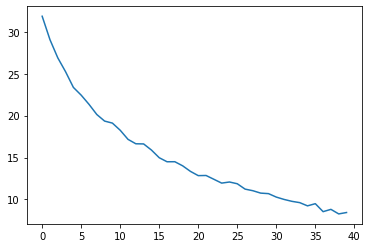

In [37]:
net = ESIM(embedding_dim=100, vocab_dim=vocab_size, hidden_size=20, class_num=n_classes, embedding=None, pad_idx=pad_idx)

train()

In [38]:
test()

acc_val:  0.7123958333333333
Counter({1: 3329, 0: 3278, 2: 3235})
[0.3286933550091445, 0.3382442592968909, 0.3330623856939646]
